<a href="https://colab.research.google.com/github/heokwon/Survey-analysis/blob/main/Calendar_Survey/Calendar_Survey_TopicModeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install konlpy
!pip install wordcloud

!pip install pyLDAvis

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 1.2 MB/s 
     |████████████████████████████████| 453 kB 54.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 7.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=d027abc0b415300e5f50d42191ee8cd42aed5d31fbe4aa4925686d129ea4caa9
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=0f18961

In [ ]:
import pickle

In [ ]:
import nltk
from nltk.util import ngrams
from nltk import word_tokenize
from nltk import ConditionalFreqDist
from nltk.probability import ConditionalProbDist, MLEProbDist
import numpy as np
import codecs
from tqdm import tqdm
import random

In [ ]:
import numpy as np
import re
import pandas as pd
from konlpy.tag import Okt
from future.utils import iteritems
from collections import Counter
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from PIL import Image
import matplotlib as mpl
import matplotlib.pylab as plb
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rcParams
import seaborn as sns
from wordcloud import WordCloud
import pyLDAvis.gensim_models
# 브라우저에서 바로 그려지도록 
# %matplotlib inline

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

# # Colab 의 한글 폰트 설정
# plt.rc('font', family='NanumSquareRound') 

# 유니코드에서  음수 부호설정
mpl.rc('axes', unicode_minus=False)

# Seaborn 테마 설정
sns.set_theme(style="ticks", color_codes=True, font='NanumSquareRound', font_scale=2)

# 워닝 메세지 삭제
import warnings
warnings.filterwarnings(action='ignore')

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


In [ ]:
import gensim
import numpy as np
import spacy

from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary

In [ ]:
## font 경로설정
font_list = [font.name for font in fm.fontManager.ttflist]
font_list
font_path = '/usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf'

In [ ]:
df=pd.read_excel('/content/re_Calendar.xlsx',index_col=0)
df

,순번,직급,직명,귀하의 소속사무소는 다음 중 어디에 해당합니까?,금년도(2022년형) 달력류 디자인 및 제작사양에 대해 전반적으로 어떻게 생각하십니까?,금년도(2022년형) 달력류 디자인에 대해 그렇게 생각하시는 이유는 무엇인가요?,금년도(2022년형) 수첩류 디자인 및 제작사양에 대해 전반적으로 어떻게 생각하십니까?,금년도(2022년형) 수첩류 디자인에 대해 그렇게 생각하시는 이유는 무엇인가요?,금년도(2022년형) 연하장류 디자인 및 제작사양에 대해 전반적으로 어떻게 생각하십니까?,금년도(2022년형) 연하장류 디자인에 대해 그렇게 생각하시는 이유는 무엇인가요?,금년도(2022년형) 달력·수첩류 배송에 대해 어떻게 생각하십니까?,금년도(2022년형) 달력·수첩류 배송에 대해 그렇게 생각하시는 이유는 무엇인가요? (선택),"농민신문사에서는 금년도(2022년형) 달력류를 각 개인에게 직접 발송하는 농민신문사 DM발송서비스를 (2형캘린더 일반·명칭형, 3형캘린더, 연하장)일부 시행했습니다. 이 서비스를 유지할 경우 이용할 의향이 있으십니까?",전제적인 구매 과정에서 개선이 필요하다고 생각했던 사항이 있으셨나요? 아래 보기 중 가장 개선이 시급한 사항을 골라주세요,2022년형 삼각식캘린더를 기존 단면월력에서 양면월력으로 변경하였는데 어떻게 생각하십니까?,2021년형 탁상용 삼각식캘린더 단면월력과 2022년형 탁상용 삼각식캘린더 양면월력 동시 판매에 대해 어떻게 생각하십니까?,"금년도(2022년형) 달력,수첩류 제품의 가격에 대해 어떻게 생각하십니까?",달력·수첩류에 대한 의견이 있으시면 구체적으로 적어주십시오.,"구매한 제품, 서비스에 대한 전반적인 만족도를 어떻게 평가 하시겠습니까?"
0,1,3급,팀장,경제지주 및 경제계열사,매우만족,다양한 색상과 크기,매우만족,다양한 색상과 크기,매우만족,다양한 색상과 크기,만족,타 업무에 집중,이용한다,기타,만족,찬성 단면월력 양면월력 동시판매,비싸다,올해 디자인 및 다양한 색상에 만족,매우만족
1,2,4급,차장,중앙회,불만족,탁상형 달력 양면인쇄,만족,NaN,보통,NaN,만족,NaN,이용한다,디자인,매우불만족,반대 단면월력으로 상품교체,비싸다,NaN,보통
2,3,4급,차장,경제지주 및 경제계열사,매우만족,전반적으로 디자인이 괜찮다고 생각함,만족,휴대용 수첩에 기존처럼 명함을 넣을 수 있도록 비닐이 있었으면 함,매우만족,사용하지 않음,매우만족,배송이 빨리 이뤄졌다고 생각함,이용하지않는다,디자인,매우만족,찬성 단면월력 양면월력 동시판매,적당하다,수첩 제작시 사용자들이 사용하기 편리하기 만들어 주었으면 함,매우만족
3,4,3급,반장,중앙회,보통,전반적으로 쏘쏘함,보통,전반적으로 쏘쏘함,보통,전반적으로 쏘쏘함,만족,전반적으로 쏘쏘함,이용한다,기타,불만족,찬성 단면월력 양면월력 동시판매,적당하다,특이사항 없음,만족
4,5,4급,차장,경제지주 및 경제계열사,만족,세련된 느낌,매우만족,트렌디하고 이쁨,매우만족,예쁨,매우만족,예쁨,이용한다,크기,매우만족,찬성 단면월력 양면월력 동시판매,적당하다,이뻐요,매우만족
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2337,2338,무기계약직,주임,경제지주 및 경제계열사,불만족,절약차원에서 앞뒤로 달이 연결되어 있는 것이 불편하다,만족,디자인과 색깔이 좋은 거 같다,보통,연하장을 본 적이 없어서 잘 모르겠다,보통,배송을 직접 담당하지 않아서 잘 모르겠다,모르겠다,디자인,불만족,반대 단면월력으로 상품교체,비싸다,달력은 단면이 실용적이다,보통
2338,2339,-,영양사,중앙회,매우만족,무난함,매우만족,디자인이 깔끔하고 내용도 좋고 자석뭍임 여닫음이 좋음,매우만족,무난함,보통,느렸음,모르겠다,배송,보통,찬성 단면월력 양면월력 동시판매,적당하다,없음,만족
2339,2340,기타,기타,금융지주 및 금융계열사,매우만족,깔끔하고 심플합니다,매우만족,디자인 만족,보통,거의 사용하지 않음,매우만족,잘 배송되어서 만족,이용한다,소재 품질,매우만족,찬성 단면월력 양면월력 동시판매,적당하다,대체적으로 만족,만족
2340,2341,-,주임,중앙회,만족,ㅎ,만족,ㅎ,만족,ㅎ,만족,ㅎ,모르겠다,크기,만족,반대 단면월력으로 상품교체,적당하다,ㅎ,만족


## WordCloud with TextRank

### 데이터 전처리

In [ ]:
def clean_content(content):
  cleaned = re.sub('[^가-힣ㄱ-ㅣa-zA-Z|.%]', ' ', string=str(content))
  cleaned = re.sub('[-=+,#/\?:^.@*\"※~ㆍ!』‘|\(\)\[\]`\'…》\”\“\’·]', ' ', cleaned)
  return cleaned

col_lst = [i for i in df.columns[3:]]
for i in col_lst:
    df[i] = df[i].apply(clean_content)
df

,순번,직급,직명,귀하의 소속사무소는 다음 중 어디에 해당합니까?,금년도(2022년형) 달력류 디자인 및 제작사양에 대해 전반적으로 어떻게 생각하십니까?,금년도(2022년형) 달력류 디자인에 대해 그렇게 생각하시는 이유는 무엇인가요?,금년도(2022년형) 수첩류 디자인 및 제작사양에 대해 전반적으로 어떻게 생각하십니까?,금년도(2022년형) 수첩류 디자인에 대해 그렇게 생각하시는 이유는 무엇인가요?,금년도(2022년형) 연하장류 디자인 및 제작사양에 대해 전반적으로 어떻게 생각하십니까?,금년도(2022년형) 연하장류 디자인에 대해 그렇게 생각하시는 이유는 무엇인가요?,금년도(2022년형) 달력·수첩류 배송에 대해 어떻게 생각하십니까?,금년도(2022년형) 달력·수첩류 배송에 대해 그렇게 생각하시는 이유는 무엇인가요? (선택),"농민신문사에서는 금년도(2022년형) 달력류를 각 개인에게 직접 발송하는 농민신문사 DM발송서비스를 (2형캘린더 일반·명칭형, 3형캘린더, 연하장)일부 시행했습니다. 이 서비스를 유지할 경우 이용할 의향이 있으십니까?",전제적인 구매 과정에서 개선이 필요하다고 생각했던 사항이 있으셨나요? 아래 보기 중 가장 개선이 시급한 사항을 골라주세요,2022년형 삼각식캘린더를 기존 단면월력에서 양면월력으로 변경하였는데 어떻게 생각하십니까?,2021년형 탁상용 삼각식캘린더 단면월력과 2022년형 탁상용 삼각식캘린더 양면월력 동시 판매에 대해 어떻게 생각하십니까?,"금년도(2022년형) 달력,수첩류 제품의 가격에 대해 어떻게 생각하십니까?",달력·수첩류에 대한 의견이 있으시면 구체적으로 적어주십시오.,"구매한 제품, 서비스에 대한 전반적인 만족도를 어떻게 평가 하시겠습니까?"
0,1,3급,팀장,경제지주 및 경제계열사,매우만족,다양한 색상과 크기,매우만족,다양한 색상과 크기,매우만족,다양한 색상과 크기,만족,타 업무에 집중,이용한다,기타,만족,찬성 단면월력 양면월력 동시판매,비싸다,올해 디자인 및 다양한 색상에 만족,매우만족
1,2,4급,차장,중앙회,불만족,탁상형 달력 양면인쇄,만족,nan,보통,nan,만족,nan,이용한다,디자인,매우불만족,반대 단면월력으로 상품교체,비싸다,nan,보통
2,3,4급,차장,경제지주 및 경제계열사,매우만족,전반적으로 디자인이 괜찮다고 생각함,만족,휴대용 수첩에 기존처럼 명함을 넣을 수 있도록 비닐이 있었으면 함,매우만족,사용하지 않음,매우만족,배송이 빨리 이뤄졌다고 생각함,이용하지않는다,디자인,매우만족,찬성 단면월력 양면월력 동시판매,적당하다,수첩 제작시 사용자들이 사용하기 편리하기 만들어 주었으면 함,매우만족
3,4,3급,반장,중앙회,보통,전반적으로 쏘쏘함,보통,전반적으로 쏘쏘함,보통,전반적으로 쏘쏘함,만족,전반적으로 쏘쏘함,이용한다,기타,불만족,찬성 단면월력 양면월력 동시판매,적당하다,특이사항 없음,만족
4,5,4급,차장,경제지주 및 경제계열사,만족,세련된 느낌,매우만족,트렌디하고 이쁨,매우만족,예쁨,매우만족,예쁨,이용한다,크기,매우만족,찬성 단면월력 양면월력 동시판매,적당하다,이뻐요,매우만족
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2337,2338,무기계약직,주임,경제지주 및 경제계열사,불만족,절약차원에서 앞뒤로 달이 연결되어 있는 것이 불편하다,만족,디자인과 색깔이 좋은 거 같다,보통,연하장을 본 적이 없어서 잘 모르겠다,보통,배송을 직접 담당하지 않아서 잘 모르겠다,모르겠다,디자인,불만족,반대 단면월력으로 상품교체,비싸다,달력은 단면이 실용적이다,보통
2338,2339,-,영양사,중앙회,매우만족,무난함,매우만족,디자인이 깔끔하고 내용도 좋고 자석뭍임 여닫음이 좋음,매우만족,무난함,보통,느렸음,모르겠다,배송,보통,찬성 단면월력 양면월력 동시판매,적당하다,없음,만족
2339,2340,기타,기타,금융지주 및 금융계열사,매우만족,깔끔하고 심플합니다,매우만족,디자인 만족,보통,거의 사용하지 않음,매우만족,잘 배송되어서 만족,이용한다,소재 품질,매우만족,찬성 단면월력 양면월력 동시판매,적당하다,대체적으로 만족,만족
2340,2341,-,주임,중앙회,만족,ㅎ,만족,ㅎ,만족,ㅎ,만족,ㅎ,모르겠다,크기,만족,반대 단면월력으로 상품교체,적당하다,ㅎ,만족


In [ ]:
okt = Okt()
df = df['금년도(2022년형) 수첩류 디자인에 대해 그렇게 생각하시는 이유는 무엇인가요?'].apply(okt.morphs, stem=True)

In [ ]:
def oneWordRemoval(lst):
  for el in lst:
    if len(el) <= 1:
      lst.remove(el)

df.apply(oneWordRemoval)

0       None
1       None
2       None
3       None
4       None
        ... 
2337    None
2338    None
2339    None
2340    None
2341    None
Name: 금년도(2022년형) 수첩류 디자인에 대해 그렇게 생각하시는 이유는 무엇인가요?, Length: 2342, dtype: object

In [ ]:
## 불용어 사전
stop_words = '수, nan, 없다, P, 없음, 등, 않은, 이, 의, 있, 하, 것, 들, 그, 되, 보, 않, 없, 나, 주, 같, 때, 도, 을, 는, 가, 에'
stop_words =  stop_words.split(', ')

## 불용어 제거
def del_stop(data):
  words = []
  for w in data:
    if w not in stop_words:
      words.append(w)
  return words

df = df.apply(del_stop)

### TF-IDF 구축

In [ ]:
dictionary = gensim.corpora.Dictionary(df)
BoW_corpus = [dictionary.doc2bow(doc, allow_update=True) for doc in df]
tfidf = gensim.models.TfidfModel(BoW_corpus, smartirs='ntc')

In [ ]:
with open('tfidf.txt', 'wb') as f:
  pickle.dump(tfidf, f)

In [ ]:
num = 0
for doc in tfidf[BoW_corpus]:
  for id, freq in doc:
    num += 1

In [ ]:
tfidf_dic = {dictionary.get(id): freq for doc in tfidf[BoW_corpus] for id, freq in doc}

In [ ]:
toDataFrame = {
  '단어': tfidf_dic.keys(),
  '빈도': tfidf_dic.values(),    
}

pd.DataFrame(toDataFrame)

,단어,빈도
0,다양하다,0.241291
1,색상,0.495082
2,크기,0.484005
3,기존,0.211766
4,넣다,0.321099
...,...,...
1281,이또,0.405827
1282,혁신,0.468861
1283,몰다,0.355386
1284,뭍임,0.562770


In [ ]:
od = {v: k for k, v in tfidf_dic.items()}
ordered_keys = sorted(od.keys())
tfidf_od = {od[k]: k for k in ordered_keys}

In [ ]:
keys = list(tfidf_od.keys())
keys.reverse()
for i in range(50):
  key = keys[i]
  print(key, tfidf_od[key])

깨꿋 1.0
심풀 0.9698202471908588
큼직큼직하다 0.9652907805402399
사다 0.9604512674974125
문안 0.952878132810609
말끔 0.9510080729791217
쏘다 0.9497159879465116
포장재 0.9481889683217578
넓다 0.9379730397379181
다양성 0.9351810653010705
보기 0.9311514821406847
받다 0.929733293253275
형 0.9216461132249824
메우다 0.9179905363046504
예쁘다 0.9060024478363994
두툼 0.905832687286102
끌리다 0.8972673663100342
짜이다 0.8970438392725433
정갈하다 0.8939882487712915
비싸다 0.8873810769835484
따다 0.8855607652633845
드 0.8841636908301584
편안함 0.8760688844390021
작아지다 0.8750654505469282
밝다 0.8740618387276327
편안하다 0.8718989731834803
ㅁ 0.8712816525245021
불만족 0.8688463671569754
만족 0.8643102864106756
새롭다 0.8622666827100068
맘에듬 0.8621518070940495
그러하다 0.861121654426456
선명하다 0.8584677043369211
깨끗하다 0.8570122010504785
대체로 0.8564639802861156
돋보이다 0.8562669503826461
입력 0.8503665313405553
동일 0.8470566753193777
구식 0.8469698827883309
뚱뚱하다 0.8363536581755148
컷으 0.8354792573271735
부재 0.8227170935110492
실패 0.8186923089058422
뜨다 0.8186588835939698
식용 0.8179896240599015


### 워드클라우드

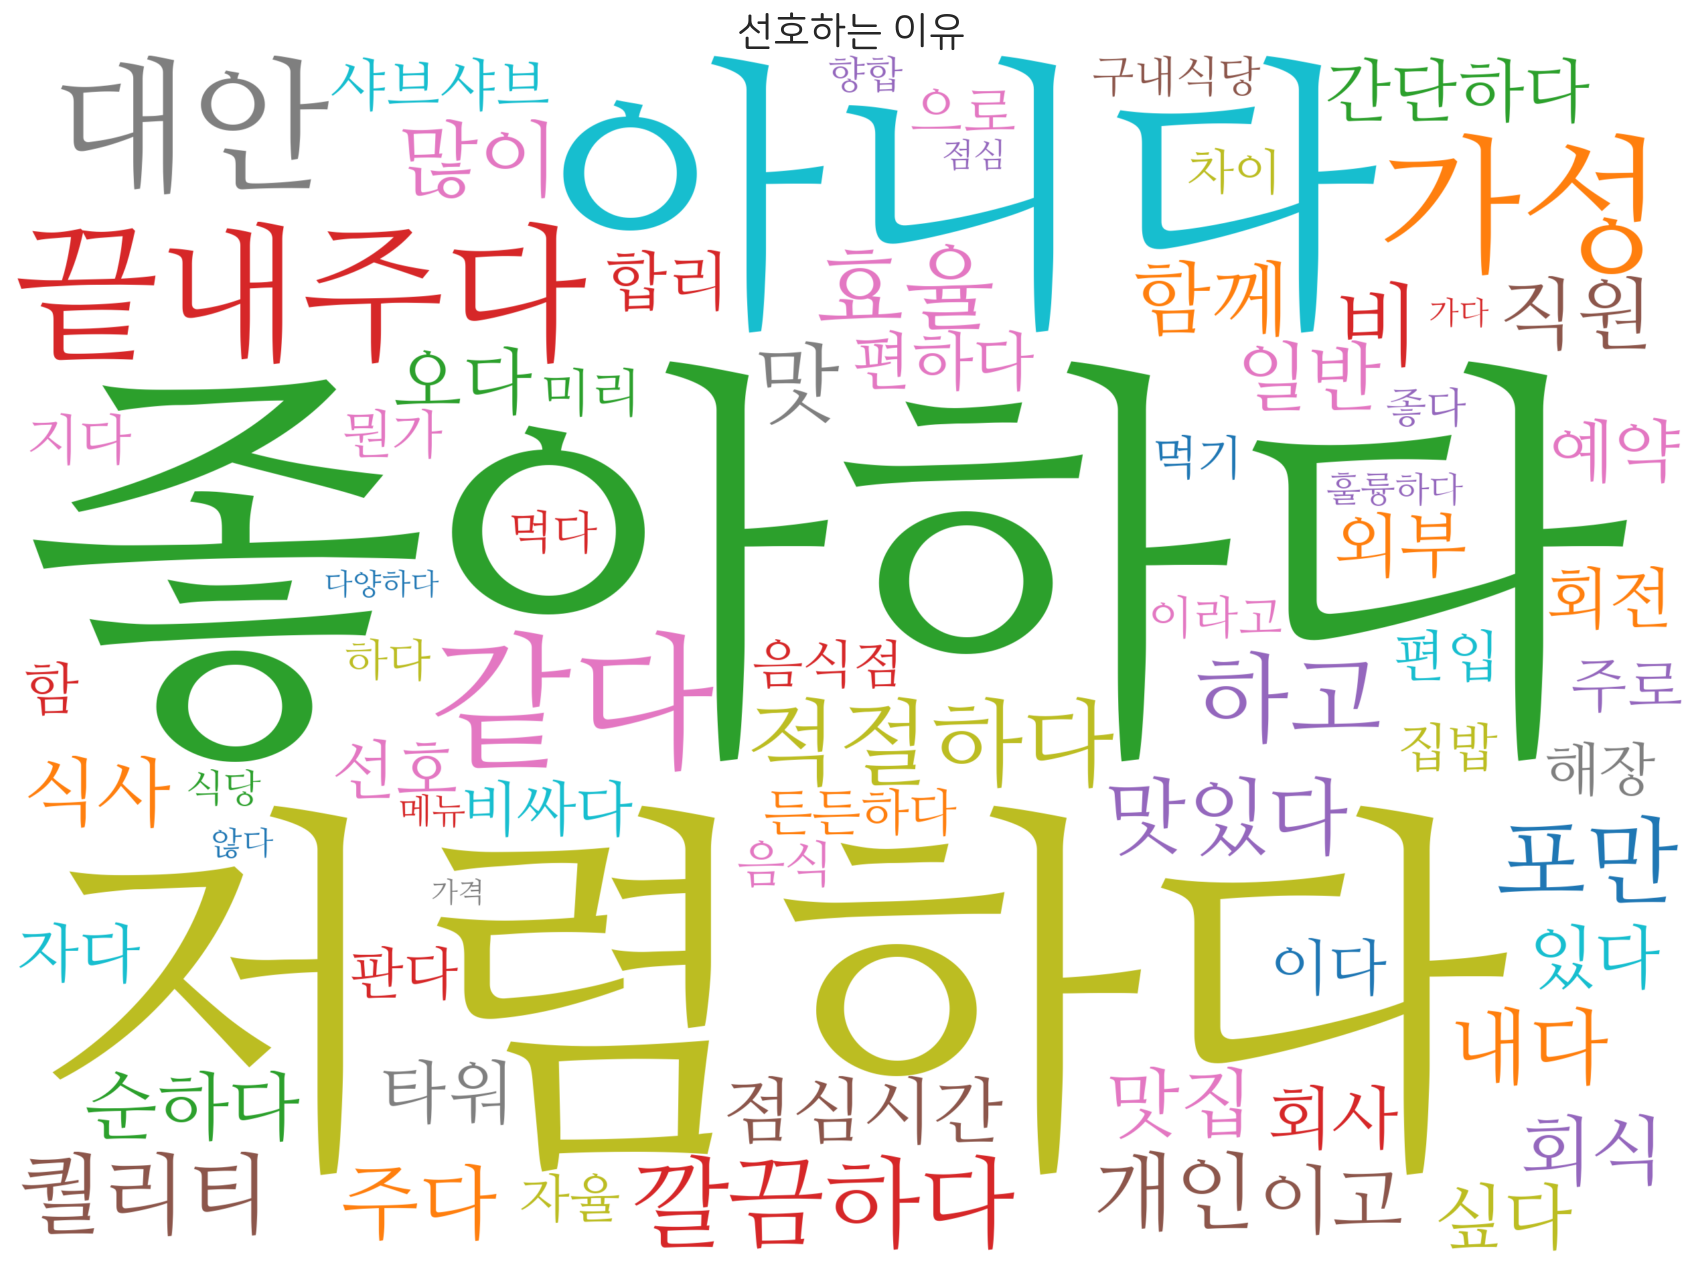

In [ ]:
cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  # max_words=10,
                  colormap='tab10',
                  prefer_horizontal=1.0,
                  font_path=font_path).fit_words(tfidf_od)

plt.figure(figsize = (15, 20)) 
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.title("선호하는 이유", size = 20) # 제목 지정

plt.show()

## LDA 토픽모델링

In [ ]:
from datetime import datetime
from time import time
from gensim.models.coherencemodel import CoherenceModel

In [ ]:
num_topics = 4 # 토픽 수 설정
chunksize = 2000 # 한번에 처리할 row 수 설정
passes = 100 # 에폭 Number of passes through the corpus during training.
iterations = 400 # Maximum number of iterations through the corpus when inferring the topic distribution of a corpus.
eval_every = None # log 복잡도 계산 수행 유무 설정 1로 설정하면 학습이 2배로 느려짐
random_state = 100 # 재실행 시 같은 결과를 같기 위해 난수 설정

lda_model = gensim.models.ldamodel.LdaModel(corpus=tfidf[BoW_corpus],
                                            id2word=dictionary,
                                            num_topics=num_topics,
                                            chunksize=chunksize,
                                            passes=passes,
                                            iterations=iterations,
                                            random_state=random_state,
                                            eval_every=eval_every,)

In [ ]:
print(lda_model.print_topics())

[(0, '0.064*"좋다" + 0.046*"만족" + 0.039*"색상" + 0.037*"디자인" + 0.027*"크기" + 0.024*"전반" + 0.019*"으로" + 0.018*"세련되다" + 0.017*"선택" + 0.013*"괜찮다"'), (1, '0.036*"심플" + 0.024*"불만족" + 0.022*"재질" + 0.019*"하다" + 0.018*"사용" + 0.017*"디자인" + 0.015*"색상" + 0.014*"만족스럽다" + 0.014*"평범하다" + 0.013*"스럽다"'), (2, '0.037*"깔끔하다" + 0.034*"보통" + 0.019*"이다" + 0.016*"메모" + 0.014*"디자인" + 0.014*"있다" + 0.014*"수첩" + 0.014*"사이즈" + 0.013*"예쁘다" + 0.013*"너무"'), (3, '0.046*"만족하다" + 0.042*"무난" + 0.020*"촌스럽다" + 0.020*"마음" + 0.019*"하다" + 0.018*"들다" + 0.018*"디자인" + 0.013*"모르다" + 0.013*"색상" + 0.011*"색깔"')]


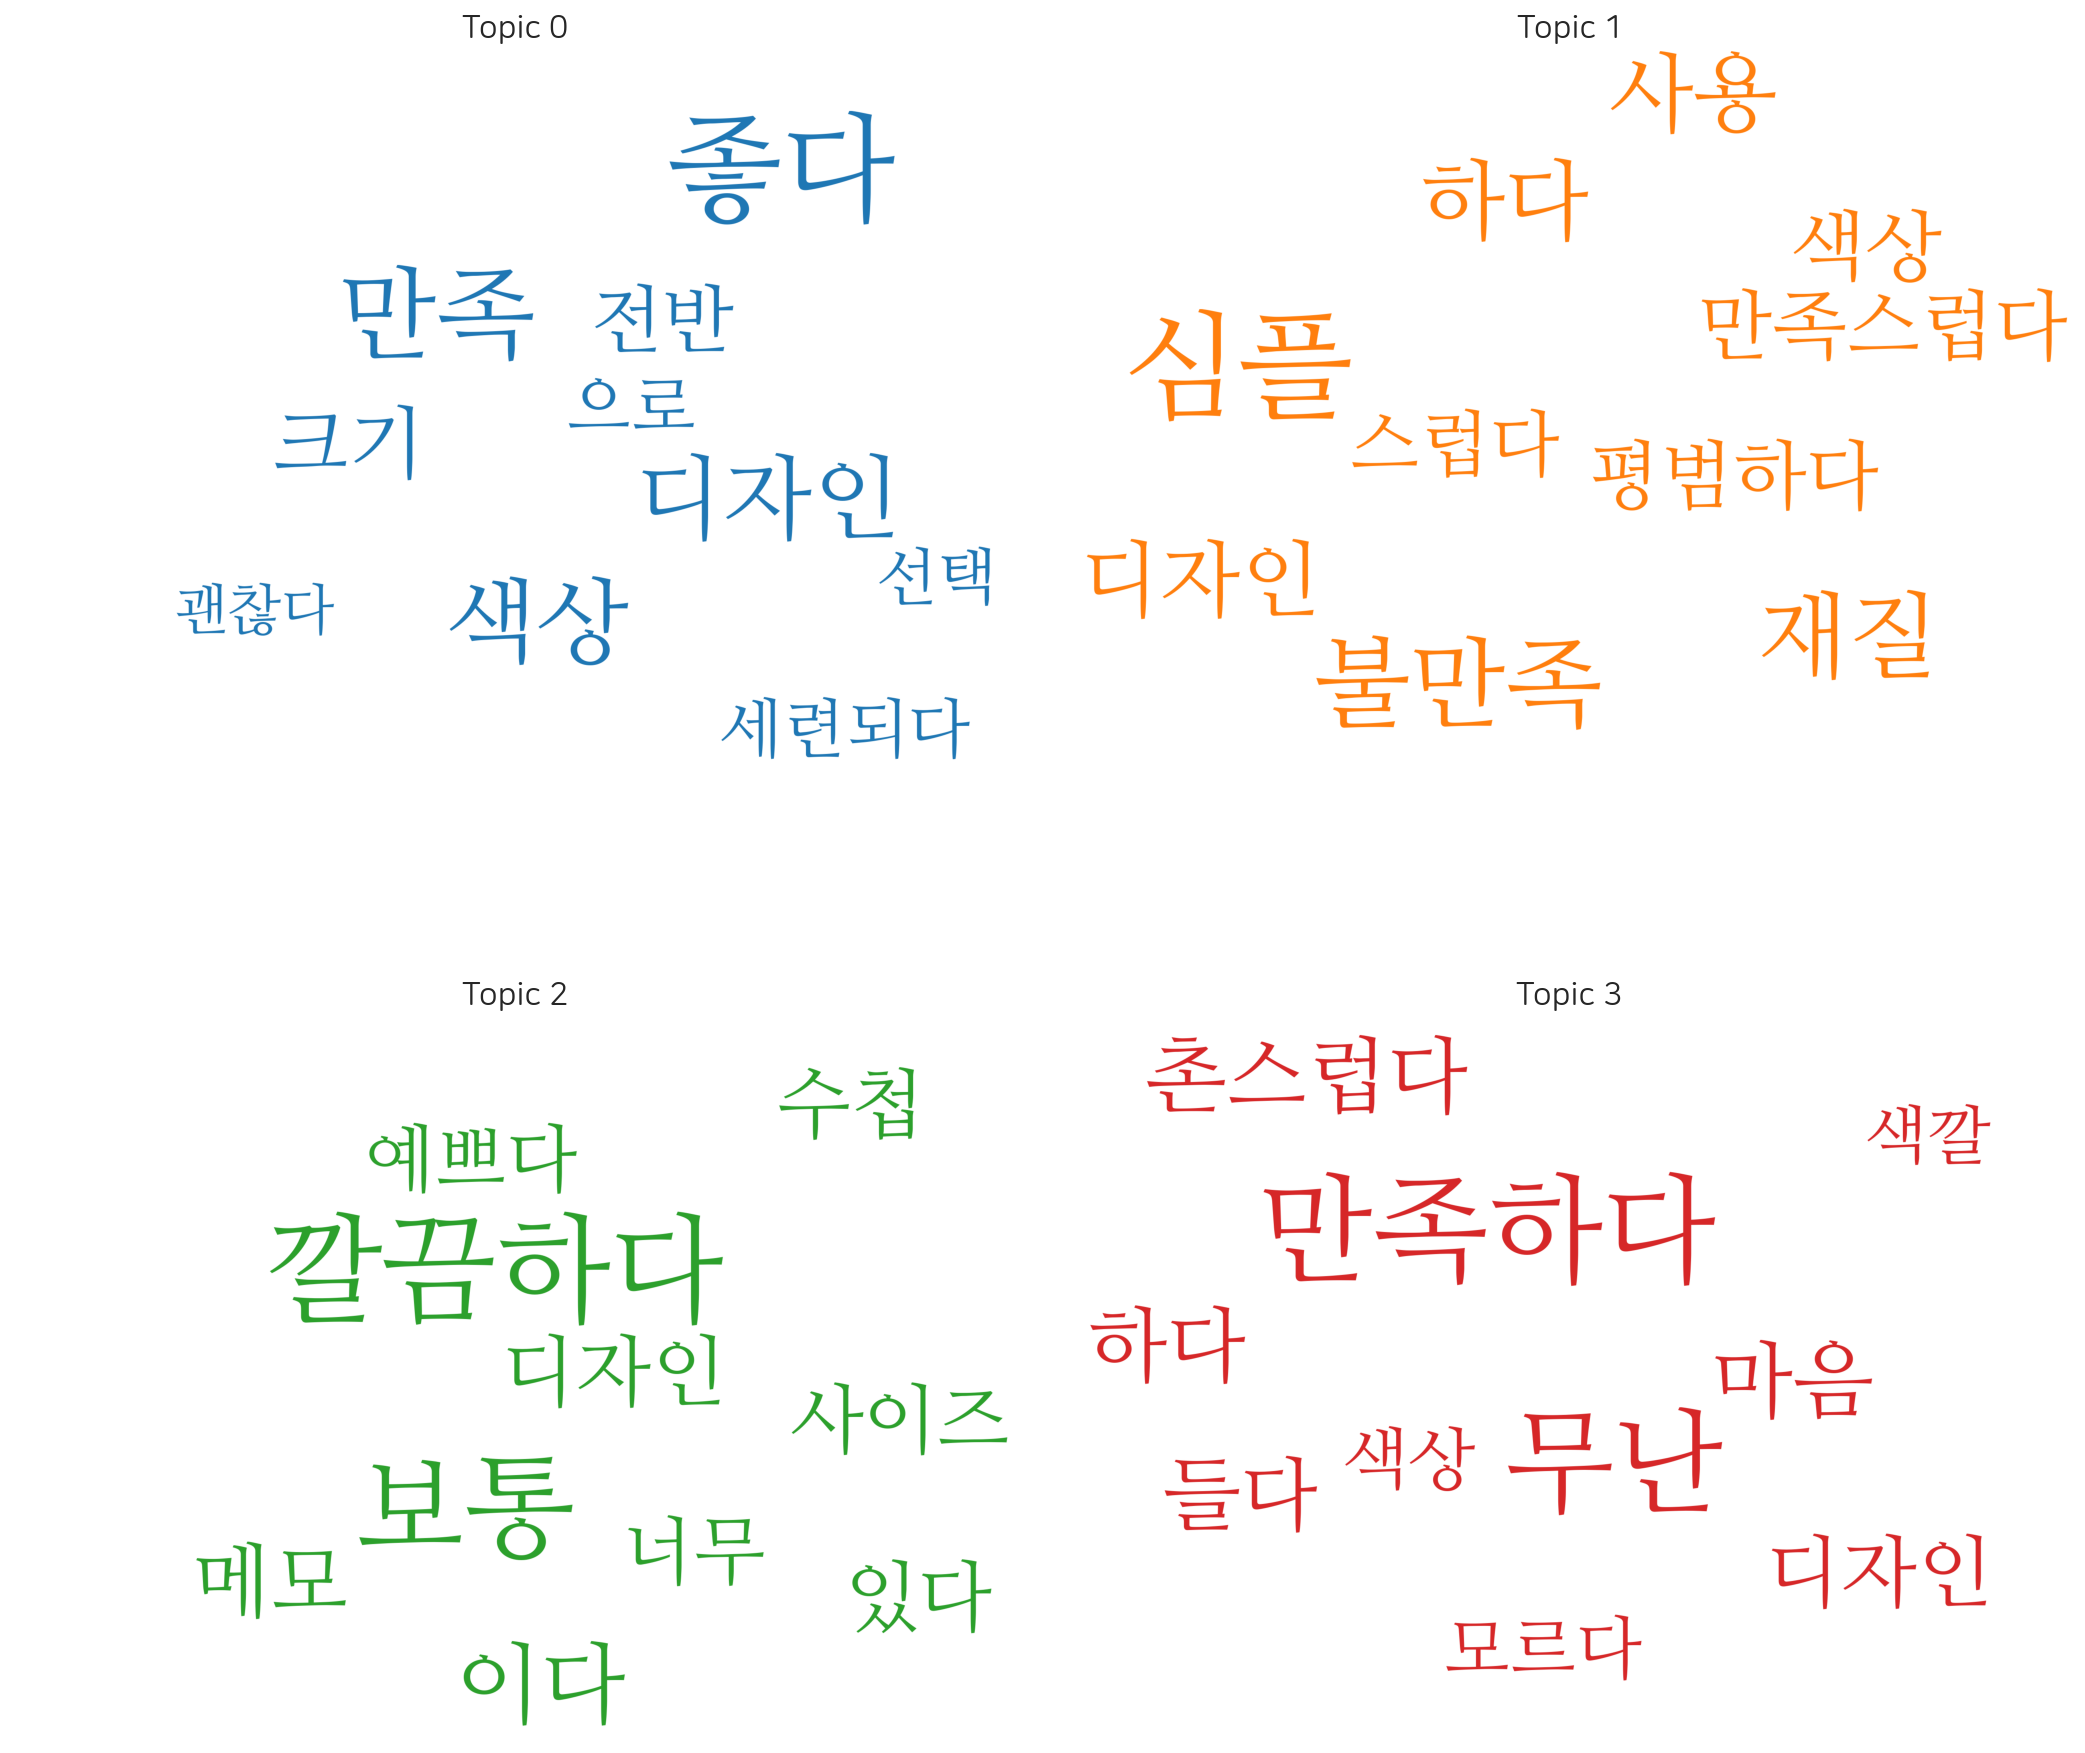

In [ ]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0,
                  font_path=font_path)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(15,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, tfidf[BoW_corpus], dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.151412  0.111418       1        1  33.801400
0     -0.172354  0.067983       2        1  23.849485
3      0.033135 -0.161940       3        1  22.390721
1     -0.012193 -0.017460       4        1  19.958395, topic_info=     Term       Freq      Total Category  logprob  loglift
31     만족  36.000000  36.000000  Default  30.0000  30.0000
26   만족하다  33.000000  33.000000  Default  29.0000  29.0000
219    무난  30.000000  30.000000  Default  28.0000  28.0000
43   깔끔하다  41.000000  41.000000  Default  27.0000  27.0000
33     좋다  71.000000  71.000000  Default  26.0000  26.0000
..    ...        ...        ...      ...      ...      ...
55     보임   3.083071   5.180792   Topic4  -5.3482   1.0925
117  다이어리   3.843251  11.760350   Topic4  -5.1278   0.4931
7      수첩   4.649833  29.697693   Topic4  -4.9373  -0.2427
155  불편하다   3.796731  17.795408   Topic4  -5.1400   0.0667
103    색깔   3.703016  17.661600   Topic4  -5.1650   0.0493

[213 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
433       3  0.869086   가볍다
157       2  0.720865    가죽
157       3  0.180216    가죽
23        1  0.586953    같다
23        3  0.320156    같다
...     ...       ...   ...
475       3  0.694703    형식
342       4  0.676164   호불호
261       3  0.738105  화려하다
375       3  0.986635    회색
558       1  0.897754    효율

[220 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 4, 2])